# Crack Segmentation using Mask RCNN from Detectron 2

#### 1. Setup

In [1]:
!nvidia-smi

Sun Jun 11 14:23:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   79C    P0    N/A /  N/A |    777MiB /  4046MiB |     56%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/ayushman/anaconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
torch:  1.13 ; cuda:  1.13.0
detectron2: 0.6


In [3]:
# COMMON LIBRARIES
import os
import cv2
import matplotlib.pyplot as plt
from datetime import datetime


# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

#### 2. Register Dataset

In [4]:
DATASET_NAME = "crack_coco_segmentation"
DATASET_PATH = "./data/crack_coco_segmentation/"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [5]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATASET_PATH, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(DATASET_PATH, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATASET_PATH, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(DATASET_PATH, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALIDATION SET
VALID_DATA_SET_NAME = f"valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATASET_PATH, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(DATASET_PATH, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)



#### 3. Data Exploration


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



(-0.5, 331.5, 331.5, -0.5)

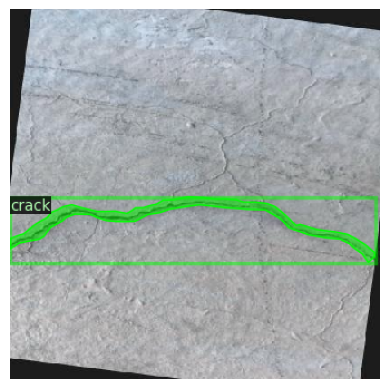

In [9]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[5] ##note: the indices are based on the annotation file
image = cv2.imread(dataset_entry["file_name"]) # reads the file name attribute of the id 1 data in the json file 

visualizer = Visualizer(
    img_rgb=image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode = ColorMode.SEGMENTATION
)

out = visualizer.draw_dataset_dict(dataset_entry)
output_image = out.get_image()[:, :, ::-1]

plt.imshow(output_image)
plt.axis('off')

In [7]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_50_FPN_1x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 1

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATASET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH